In [1]:
import sqlite3
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
conn = sqlite3.connect('instacart.db')

import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def plot_categorical(feature, df,color='lightblue', ro=0):
    '''draw plot for categorical variables '''
    ax = df[feature].value_counts().plot(kind='bar',
                                    figsize=(15,10), 
                                    color=color)
    ax.set_xlabel(feature,fontsize=6)
    ax.set_ylabel("Count",fontsize=14)
    ax.tick_params(labelsize=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(ro)
    return

In [5]:
aisles=pd.read_csv("aisles.csv")
departments=pd.read_csv("departments.csv")
order_products=pd.read_csv("order_products.csv")
orders=pd.read_csv("orders.csv")
products=pd.read_csv("products.csv")
users_sampled=pd.read_csv("users_sampled.csv")

In [6]:
print(aisles.head())
print(departments.head())
print(order_products.head())
print(products.head())
print(orders.head())
print(users_sampled.head())

   index  al_id                       aisle
0      0      1       prepared soups salads
1      1      2           specialty cheeses
2      2      3         energy granola bars
3      3      4               instant foods
4      4      5  marinades meat preparation
   index  dt_id       dt
0      0      1   frozen
1      1      2    other
2      2      3   bakery
3      3      4  produce
4      4      5  alcohol
   order_id  prod_id  cart_order  reorder
0         2    33120           1        1
1         2    28985           2        1
2         2     9327           3        0
3         2    45918           4        1
4         2    30035           5        0
   index  prod_id                                          prod_name  al_id  \
0      0        1                         Chocolate Sandwich Cookies     61   
1      1        2                                   All-Seasons Salt    104   
2      2        3               Robust Golden Unsweetened Oolong Tea     94   
3      3        4 

### check how many items in each order

In [8]:
od_prod = order_products[['order_id','prod_id']].groupby('order_id',as_index=False).agg("count").rename(columns={"prod_id":"counts"})

print(list(od_prod.columns))
od_prod.head()



['order_id', 'counts']


,order_id,counts
0,2,9
1,4,13
2,15,5
3,19,3
4,27,27


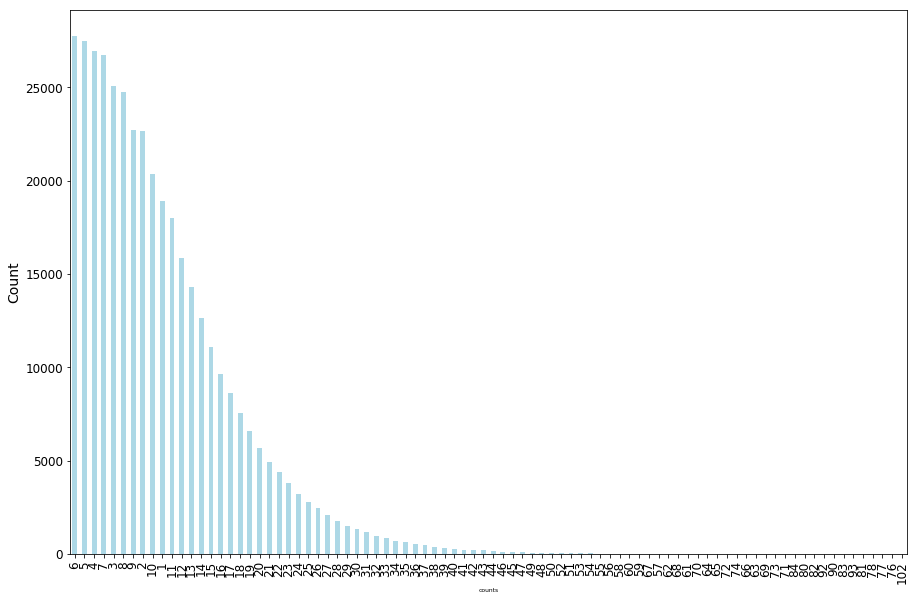

In [9]:
plot_categorical('counts',od_prod, color='lightblue', ro=90)

In [10]:
df1 =  pd.merge(od_prod, orders)
df1.head()

,order_id,counts,user_id,order_n,order_dow,order_hr,d_prior
0,2,9,202279,3,5,9,8.0
1,4,13,178520,36,1,9,7.0
2,15,5,54901,51,3,11,2.0
3,19,3,83009,7,5,17,13.0
4,27,27,129389,16,6,20,14.0


### Order sequence number is highly correlated with number of days since last order
Insights: Customers tend to shop more frequently when they made more orders


             counts   order_n  order_dow  order_hr   d_prior
counts     1.000000 -0.005538  -0.028022 -0.003450  0.057115
order_n   -0.005538  1.000000   0.015275 -0.032892 -0.362262
order_dow -0.028022  0.015275   1.000000  0.005403 -0.029348
order_hr  -0.003450 -0.032892   0.005403  1.000000 -0.002718
d_prior    0.057115 -0.362262  -0.029348 -0.002718  1.000000


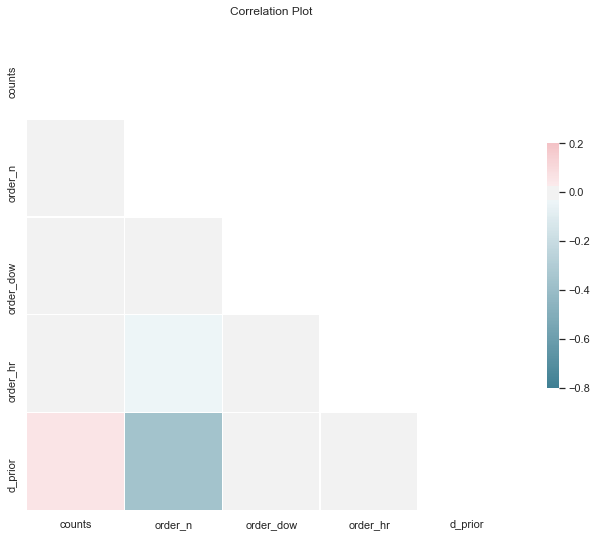

In [11]:
df1_1 = df1.copy().drop(['order_id',"user_id"], axis=1)
print(df1_1.corr())
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df1_1
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Correlation Plot")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.2, vmin= -0.8,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Exploration of new vs existed customers

In [12]:
# create lables for new vs existed customers

df1_1.order_n.describe()
df1_1['new_c'] = np.where(df1_1.order_n==1,'new','old')
df1_1.head()

,counts,order_n,order_dow,order_hr,d_prior,new_c
0,9,3,5,9,8.0,old
1,13,36,1,9,7.0,old
2,5,51,3,11,2.0,old
3,3,7,5,17,13.0,old
4,27,16,6,20,14.0,old


In [13]:
df2 =  pd.merge(order_products, products)

In [14]:
df2.head()

,order_id,prod_id,cart_order,reorder,index,prod_name,al_id,dt_id
0,2,33120,1,1,33119,Organic Egg Whites,86,16
1,390,33120,28,1,33119,Organic Egg Whites,86,16
2,1097,33120,14,1,33119,Organic Egg Whites,86,16
3,1887,33120,6,1,33119,Organic Egg Whites,86,16
4,3304,33120,4,1,33119,Organic Egg Whites,86,16


#### When do people order?

In [94]:
df1_1.order_dow.describe()

count    389772.000000
mean          2.771492
std           2.041655
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: order_dow, dtype: float64

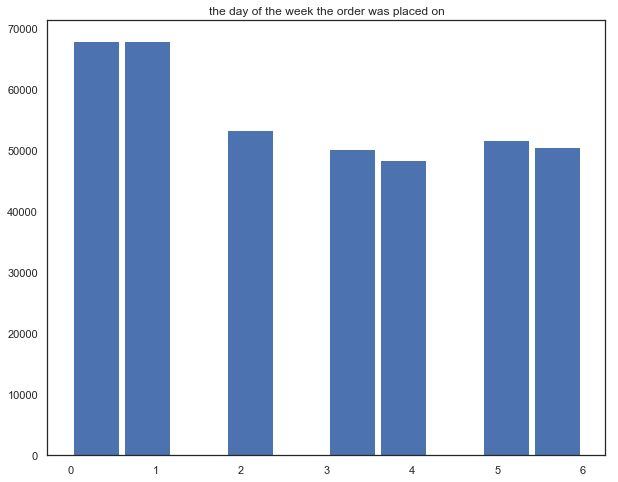

In [93]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('the day of the week the order was placed on')
plt.hist(df1_1.order_dow,rwidth=0.9)

pass

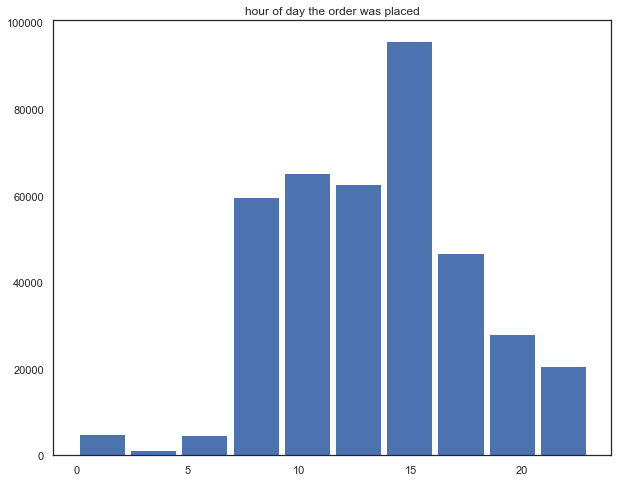

In [95]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('hour of day the order was placed')
plt.hist(df1_1.order_hr,rwidth=0.9)

pass

#### When do they order again?

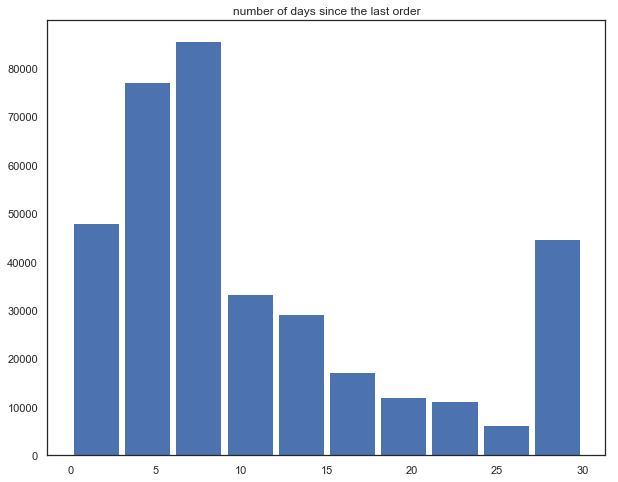

In [68]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('number of days since the last order')
plt.hist(df1_1.d_prior,rwidth=0.9)

pass

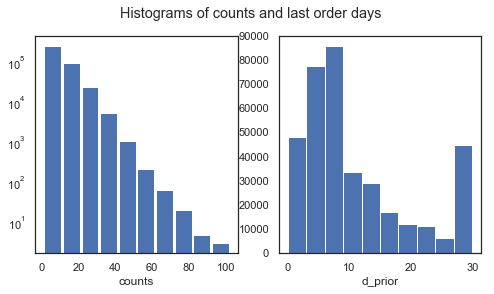

In [17]:
fig1,axes1=plt.subplots(1,2,figsize=(8,4))
fig1.suptitle("Histograms of counts and last order days")

axes1[0].hist(df1_1.counts,rwidth=0.9)
axes1[0].set_yscale("log")
axes1[0].set_xlabel("counts")
axes1[1].hist(df1_1.d_prior )
# axes1[1].set_xticks([0,1])
axes1[1].set_xlabel("d_prior")

pass

#### No significant patterns between cart order and reorder

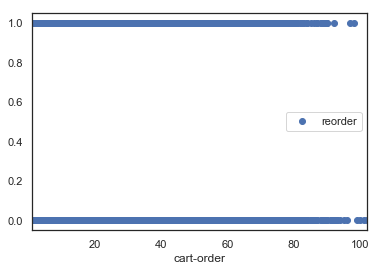

In [78]:
order_products.plot(x='cart-order', y='reorder', style='o')

### New customer vs old customer

In [20]:
tt= df1_1.new_c== 'new'
new = df1_1[tt]
print(new.head())

old = df1_1[-tt]
print(old.head())

    counts  order_n  order_dow  order_hr  d_prior new_c
10      10        1          0        11      NaN   new
11      14        1          0        15      NaN   new
31       1        1          5        18      NaN   new
37      16        1          0        11      NaN   new
38       6        1          1        15      NaN   new
   counts  order_n  order_dow  order_hr  d_prior new_c
0       9        3          5         9      8.0   old
1      13       36          1         9      7.0   old
2       5       51          3        11      2.0   old
3       3        7          5        17     13.0   old
4      27       16          6        20     14.0   old


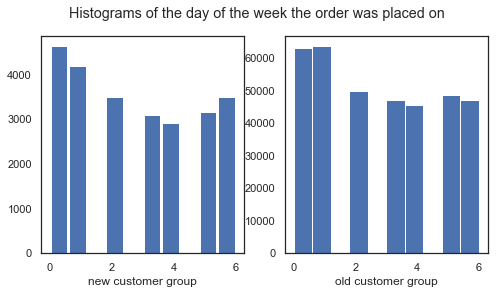

In [21]:
fig1,axes1=plt.subplots(1,2,figsize=(8,4))
fig1.suptitle("Histograms of the day of the week the order was placed on")

axes1[0].hist(new.order_dow,rwidth=0.9)

axes1[0].set_xlabel("new customer group")
axes1[1].hist(old.order_dow )

axes1[1].set_xlabel("old customer group")

pass

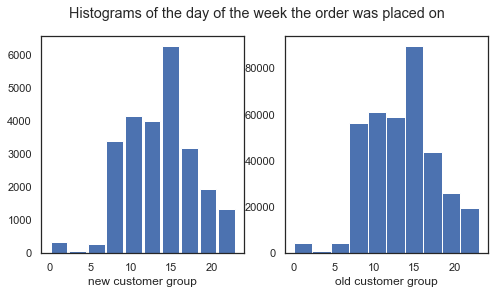

In [22]:
fig1,axes1=plt.subplots(1,2,figsize=(8,4))
fig1.suptitle("Histograms of the day of the week the order was placed on")

axes1[0].hist(new.order_hr,rwidth=0.9)

axes1[0].set_xlabel("new customer group")
axes1[1].hist(old.order_hr )

axes1[1].set_xlabel("old customer group")

pass

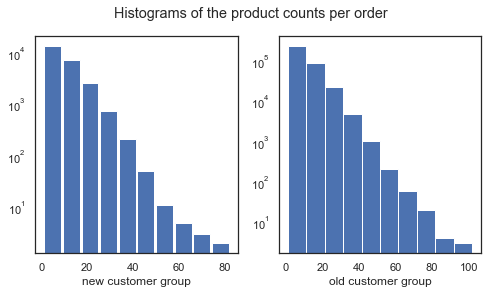

In [23]:
fig1,axes1=plt.subplots(1,2,figsize=(8,4))
fig1.suptitle("Histograms of the product counts per order")

axes1[0].hist(new.counts,rwidth=0.9)
axes1[0].set_yscale("log")
axes1[0].set_xlabel("new customer group")
axes1[1].hist(old.counts )

axes1[1].set_yscale("log")
axes1[1].set_xlabel("old customer group")

pass

### Comparison with side-by-Side histograms

Text(0.5, 1.0, 'Side-by-Side Histogram with customer groups')

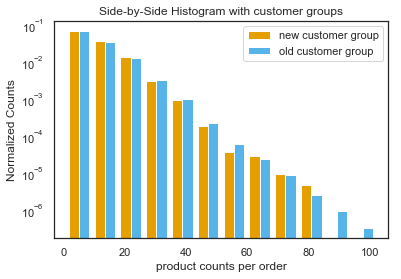

In [148]:


x1 = list(df1_1[df1_1['new_c'] == 'new']['counts'])
x2 = list(df1_1[df1_1['new_c'] == 'old']['counts'])

# Assign colors
colors = ['#E69F00', '#56B4E9']
names = ['new customer group', 'old customer group']
         
# Make the histogram using a list of lists

plt.hist([x1, x2], bins = int(180/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.yscale('log')
plt.xlabel('product counts per order')
plt.ylabel('Normalized Counts')
plt.title('Side-by-Side Histogram with customer groups')

C:\Users\Mingjie\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 1.0, 'Side-by-Side Histogram with customer groups')

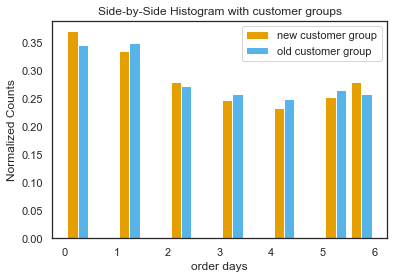

In [24]:
x1 = list(df1_1[df1_1['new_c'] == 'new']['order_dow'])
x2 = list(df1_1[df1_1['new_c'] == 'old']['order_dow'])

# Assign colors 
colors = ['#E69F00', '#56B4E9']
names = ['new customer group', 'old customer group']
         
# Make the histogram using a list of lists

plt.hist([x1, x2], bins = int(180/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('order days')
plt.ylabel('Normalized Counts')
plt.title('Side-by-Side Histogram with customer groups')

Text(0.5, 1.0, 'Side-by-Side Histogram with customer groups')

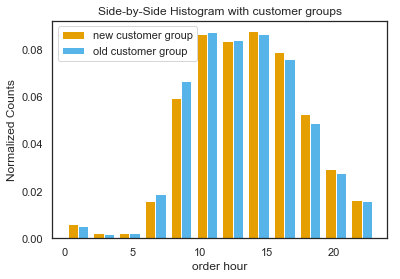

In [25]:
x1 = list(df1_1[df1_1['new_c'] == 'new']['order_hr'])
x2 = list(df1_1[df1_1['new_c'] == 'old']['order_hr'])

# Assign colors 
colors = ['#E69F00', '#56B4E9']
names = ['new customer group', 'old customer group']
         
# Make the histogram using a list of lists

plt.hist([x1, x2], bins = int(180/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('order hour')
plt.ylabel('Normalized Counts')
plt.title('Side-by-Side Histogram with customer groups')

### what do people put in the cart first

In [161]:
df2.head()

,order_id,prod_id,cart-order,reorder,index,prod_name,al_id,dt_id
0,2,33120,1,1,33119,Organic Egg Whites,86,16
1,390,33120,28,1,33119,Organic Egg Whites,86,16
2,1097,33120,14,1,33119,Organic Egg Whites,86,16
3,1887,33120,6,1,33119,Organic Egg Whites,86,16
4,3304,33120,4,1,33119,Organic Egg Whites,86,16


#### what is the most common thing people get into the cart FIRST
Banana, and other 4 organic food

In [27]:
tmp2 = df2.cart_order == 1
tmp3 = df2[tmp2][['prod_name','index','dt_id','al_id']].groupby(['prod_name','dt_id','al_id'],as_index=False).agg('count').rename(columns={"index":"counts"}).sort_values(by=['counts'])
print(tmp3.tail())
tmp3.counts.describe()

                    prod_name  dt_id  al_id  counts
14284    Organic Hass Avocado      4     24    2982
15305    Organic Strawberries      4     24    3429
15641      Organic Whole Milk     16     84    3793
1568   Bag of Organic Bananas      4     24    9549
1679                   Banana      4     24   13375


count    23719.000000
mean        16.432902
std        131.174663
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max      13375.000000
Name: counts, dtype: float64

In [28]:

tmp3 = df2[tmp2][['prod_name','reorder','dt_id','al_id']].groupby(['prod_name','dt_id','al_id'],as_index=False).agg({'reorder':['count','sum']}).reset_index().rename(columns={"reorder":"counts"})#.sort_values(by=['counts'])

print(tmp3.tail())
tmp3.head()

       index                                          prod_name dt_id al_id  \
                                                                              
23714  23714  with Sweet & Smoky BBQ Sauce Cheeseburger Sliders     1   129   
23715  23715     with Xylitol Cinnamon 18 Sticks Sugar Free Gum    19    46   
23716  23716  with Xylitol Island Berry Lime 18 Sticks Sugar...    19    46   
23717  23717  with Xylitol Original Flavor 18 Sticks Sugar F...    19    46   
23718  23718  with Xylitol Watermelon Twist 18 Sticks Sugar ...    19    46   

      counts      
       count sum  
23714      1   0  
23715      6   5  
23716      2   2  
23717      2   1  
23718      1   1  


index                               prod_name dt_id al_id counts    
                                                             count sum
0     0                       #2 Coffee Filters     7    26     12   1
1     1                   #2 Mechanical Pencils    17    87      1   0
2     2         #4 Natural Brown Coffee Filters     7    26      3   0
3     3  & Go! Hazelnut Spread + Pretzel Sticks    13    88      1   0
4     4           0% Fat Blueberry Greek Yogurt    16   120      2   0

#### what is the most common thing people get into the cart in general
Banana, and other 4 organic food, a bit different
These food has a much higher reorder rate than the reorder rate in general

In [34]:
tmp4 = df2[['prod_name','index','dt_id','al_id']].groupby(['prod_name','dt_id','al_id'],as_index=False).agg('count').rename(columns={"index":"counts"}).sort_values(by=['counts'])
print(tmp4.tail())

tmp4.counts.describe()

                    prod_name  dt_id  al_id  counts
26024    Organic Hass Avocado      4     24   25958
24694    Organic Baby Spinach      4    123   29380
27527    Organic Strawberries      4     24   32203
2933   Bag of Organic Bananas      4     24   45699
3114                   Banana      4     24   58231


count    42814.000000
mean        91.647312
std        626.601718
min          1.000000
25%          3.000000
50%         10.000000
75%         41.000000
max      58231.000000
Name: counts, dtype: float64

In [252]:
banana = (df2.prod_name == 'Banana') | (df2.prod_name == 'Bag of Organic Bananas') | (df2.prod_name == 'Organic Whole Milk') | (df2.prod_name == 'Organic Strawberries')
tmp5 = df2[banana][['prod_name','cart_order','reorder']].sort_values(by=['cart_order'])
print(tmp5.head())
print('rate of reorder',tmp5.reorder.sum()/len(tmp5.index))
# tmp5.cart_order.describe()
print('rate of reorder in general',df2.reorder.sum()/len(df2.index))

                     prod_name  cart_order  reorder
55195   Bag of Organic Bananas           1        1
183842                  Banana           1        1
183844                  Banana           1        1
183845                  Banana           1        1
183846                  Banana           1        1
rate of reorder 0.8252632682616758
rate of reorder in general 0.5885157404018769


### what is the most common thing people reorder

banana, strawberry, spinach and avocado

In [32]:
tmp4 = df2.reorder == 1
tmp5 = df2[tmp4][['prod_name','index','dt_id','al_id']].groupby(['prod_name','dt_id','al_id'],as_index=False).agg('count').rename(columns={"index":"counts"}).sort_values(by=['counts'])
print(tmp5.tail())
tmp5.counts.describe()

                    prod_name  dt_id  al_id  counts
18404    Organic Hass Avocado      4     24   20691
17336    Organic Baby Spinach      4    123   22698
19618    Organic Strawberries      4     24   25059
1972   Bag of Organic Bananas      4     24   37983
2108                   Banana      4     24   49260


count    30391.000000
mean        75.983383
std        558.115887
min          1.000000
25%          3.000000
50%          9.000000
75%         33.000000
max      49260.000000
Name: counts, dtype: float64

### What is the most popular department?
Department 4 has the most products sold

In [37]:
tmp6 = df2[['index','dt_id']].groupby(['dt_id'],as_index=False).agg('count').rename(columns={"index":"counts"}).sort_values(by=['counts'])
print(tmp6.tail())

    dt_id   counts
0       1   269145
6       7   325248
18     19   349751
15     16   655902
3       4  1152333


### What is the most popular aisle?
Aisle 24 has the most products sold

In [38]:
tmp6 = df2[['index','al_id']].groupby(['al_id'],as_index=False).agg('count').rename(columns={"index":"counts"}).sort_values(by=['counts'])
print(tmp6.tail())

     al_id  counts
20      21  117396
119    120  176682
122    123  214421
82      83  416040
23      24  443180


### Organic vs Non-organic products
9.2% of the available products are organic, however, 24% of the sold products are organic
Customers do love organic products!

In [47]:
print(products.head())

   index  prod_id                                          prod_name  al_id  \
0      0        1                         Chocolate Sandwich Cookies     61   
1      1        2                                   All-Seasons Salt    104   
2      2        3               Robust Golden Unsweetened Oolong Tea     94   
3      3        4  Smart Ones Classic Favorites Mini Rigatoni Wit...     38   
4      4        5                          Green Chile Anytime Sauce      5   

   dt_id  
0     19  
1     13  
2      7  
3      1  
4     13  


In [71]:
subs = 'Organic'
org= list(filter(lambda x: subs in x, list(products.prod_name.unique())))
print(len(org ))
print(len(list(products.prod_name.unique())))
len(list(filter(lambda x: subs in x, list(products.prod_name.unique()))) ) / (len(org )+ len(list(products.prod_name.unique())) )

5035
49688


0.10133231363709548

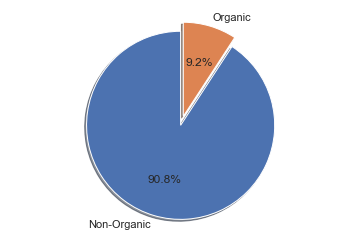

In [73]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Non-Organic', 'Organic'
sizes = [len(list(products.prod_name.unique())), len(org)]
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [75]:
pro1 = np.where(df2.prod_name.isin(org))
df2.iloc[pro1].shape[0] / (df2.shape[0] + df2.iloc[pro1].shape[0])

0.23976912067496028

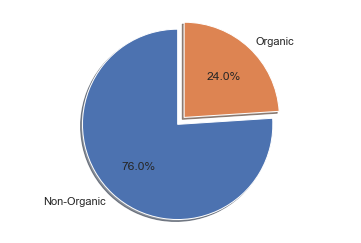

In [74]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Non-Organic', 'Organic'
sizes = [df2.shape[0], df2.iloc[pro1].shape[0]]
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()